实战：FashionMNIST时装分类
任务简介：
- 这里的任务是对10个类别的“时装”图像进行分类，使用FashionMNIST数据集。 
- FashionMNIST中数据的若干样例图，其中每个小图对应一个样本。
- FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。
- 每张图像均为单通道黑白图像，大小为28*28pixel，分属10个类别。

0.导入必要的包

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

1.配置训练环境和超参

In [3]:
# 先查看是否可以使用GPU
torch.cuda.is_available()

True

In [4]:
# 配置GPU，两种方式
## 方案1：使用os.environ   这种之后用xxx.cuda()
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'  # 这里可以是多块 0,1,2,3
# 方案2：使用device，后续要使用GPU直接用xxx.to_device(device)
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# 配置超参
batch_size = 256
num_workers = 4  # cpu4个线程来读入数据，负责将batch加载到RAM
lr = 1e-4  # 学习率  1*10^(-4)
epochs = 20  # 20比较小

2.数据的读入与加载
- 不仅要读入数据，还要读数据进行必要的变换，
- 比如说需要将图片统一为一致的大小，以便后续能够输入网络训练，
- 一般用torchvision包来完成，这是PyTorch官方用于图像处理的工具库。

In [5]:
# 首先设置数据变换
from torchvision import transforms
img_size = 28  # 因为要处理的图像大小为 28*28  单通道，灰度图
# 图像预处理
# Compose把多个步骤整合到一起：
# ToTensor()能够把灰度范围从0-255变换到0-1之间
# 后面的transform.Normalize()则把0-1变换到(-1,1)
# transform.ToTensor(),
# transform.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
# Normalize:image=(image-mean)/std
# 其中mean和std分别通过(0.5,0.5,0.5)和(0.5,0.5,0.5)进行指定
# 将ToTensor()转换的(0, 1)变成(0-0.5)/0,5 = -1  (1-0.5)/0.5=1
data_transform = transforms.Compose([
    transforms.ToPILImage(),  # 图片格式
    transforms.Resize(img_size),
    transforms.ToTensor()
])

In [6]:
# 读取方式一，用自带的
# from torchvision import datasets
# train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
# test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

In [7]:
# 读取方式二，读入csv格式的数据，自行构建Dataset类
train_df = pd.read_csv('./MNIST/fashion-mnist_train.csv')
test_df = pd.read_csv('./MNIST/fashion-mnist_test.csv')
print(train_df.shape)

(60000, 785)


In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
class FMDataset(Dataset):
    # df:dataframe
    def __init__(self, df, transform=None):
        # python类直接通过这个就可以实现
        self.df = df
        self.transform = transform
        # 取df的所有行第1列到最后的内容，第0列是label，从后面开始才是图的内容
        self.images = df.iloc[:,1:].values.astype(np.uint8)  # 专门的图像格式
        self.labels = df.iloc[:,0].values

    def __len__(self):
        return len(self.images)
    

    def __getitem__(self, idx):
        # 一条一条的读
        每一条都是784,reshape成28*28*1
        image = self.images[idx].reshape(28, 28, 1) #32*32的灰度图转为28*28 单一通道的
        label = int(self.labels[idx])
        # 对imgae和label进行处理
        if self.transform is not None: #如果转换函数非空
            image = self.transform(image) #进行数据转换
        else:
            # /255是归一化为0-1，方便处理
            image = torch.tensor(image/255, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [15]:
# 实例化
train_data = FMDataset(train_df, data_transform)
test_data = FMDataset(test_df, data_transform)

In [16]:
# 构建好Dataset后，就可以使用DataLoader来按批次读入数据
# data_set：构建好的样本
# batch_size：样本是按“批”读入的，batch_size就是每次读入的样本数 这里为256
# num_workers：有多少个进程用于读取数据
# shuffle：是否将读入的数据打乱
# drop_last：对于样本最后一部分没有达到批次数(就是不满一个batch的数量)的样本，使其不再参与训练
# pin_memory：锁页内存，设置为True，直接将内存的张量转义到GPU的显存速度会快，如果显存爆炸，就设置为False
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

torch.Size([256, 1, 28, 28]) torch.Size([256])


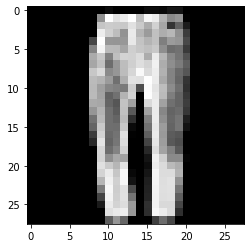

In [17]:
import matplotlib.pyplot as plt
# next是获取下一个项目
# next(iterator[,default])
# iterator ：要读取行的文件对象
# default ：如果迭代器耗尽则返回此默认值。 如果没有给出此默认值，则抛出 StopIteration 异常

images, labels = next(iter(train_loader))
print(images.shape, labels.shape)
# 展示第0个数据，第二个0为color
plt.imshow(images[0][0], cmap='gray')
plt.show()

3.模型构建
- 神经网络的构造：基于nn.Module
    - __init__, forward
- 神经网络是通过“层定义+层顺序”的方式构建起来的
- 神经网络常见层
    - nn.Conv2d, nn.MaxPool2d, nn.Linear, nn.ReLU,...

In [18]:
# 使用简单的 cnn
# Module 类是 nn 模块里提供的一个模型构造类，
# 是所有神经⽹网络模块的基类，我们可以继承它来定义我们想要的模型
class Net(nn.Module):
    # 声明Net模型有哪些类
    def __init__(self):
        # 调用Net父类Block的构造函数来进行必要的初始化。
        # 这样在构造实例时还可以指定其他函数
        super(Net, self).__init__()
        # List/Dict中元素顺序并不代表其网络中的真实位置顺序，需要forward函数指定各个层的连接顺序
        # 定义序贯模型
        self.conv = nn.Sequential(
            # 二维卷积
            # in_channels:对于最初输入图片样本的通道数 in_channels 
            # 取决于图片的类型这里数据是灰色的通道就是1个，所以就传入1；如果是RGB的图，3通道，这里就传3
            # out_channels:卷积完成之后，输出的通道数 out_channels 取决于过滤器的数量，
            # 这里的 out_channels 设置的就是过滤器的数目。
            # 对于第二层或者更多层的卷积，此时的 in_channels 就是上一层的 out_channels ， out_channels 还是取决于过滤器数目
            # kernel_size,  卷积核设置为5*5
            # stride=1,
            # padding=0,
            # dilation=1,
            # groups=1,
            # bias=True,
            # padding_mode='zeros',
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            # kernel_size ：表示做最大池化的窗口大小，可以是单个值（单*单），也可以是tuple元组
            # stride ：步长，可以是单个值（向右滑动2个窗口，向下滑动2个窗口），也可以是tuple元组
            # padding ：填充，可以是单个值，也可以是tuple元组
            # dilation ：控制窗口中元素步幅
            # return_indices ：布尔类型，返回最大值位置索引
            # ceil_mode ：布尔类型，为True，用向上取整的方法，计算输出形状；默认是向下取整。
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            # 第二层卷积的in_channels就是第一层的out_channels
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # Dropout是为了防止过拟合而设置的
            # Dropout顾名思义有丢掉的意思
            # nn.Dropout(p = 0.3) # 表示每个神经元有0.3的可能性不被激活
            # Dropout只能用在训练部分而不能用在测试部分
            # Dropout一般用在全连接神经网络映射层之后，如代码的nn.Linear(20, 30)之后
            nn.Dropout(0.3)
        )
        # 全连接层
        self.fc = nn.Sequential(
            # in_features：输入的神经元个数
            # out_features：输出神经元个数
            # bias=True：是否包含偏置
            # 其实Linear其实就是对输入X(n*i)执行了一个线性变换，即：
            # y = XW + b 其实W是模型要学习的参数，W的维度为i*o，b是o维的向量偏置，n微输入向量的行数
            # （例如，一次输入10个样本，即batch_size为10，则n=10），i为输入神经元的个数（例如样本的特征书为5，则i=5）
            # o为输出神经元的个数
            # 例如，定义线性层，我们的输入特征为5，所以in_feature=5，
            # 我们想让下一层的神经元个数为10，所以out_feature=10，则模型参数为：W(5 × 10)
            # 这里输入特征数为64*4*4，输出特征数为512
            # 本来说32*32的特征（32*32的大小）
            nn.Linear(64*4*4, 512),
            # F.relu(input)一般在forward函数里面使用，这个一般在初始化的时候使用，
            # 例如F.relu(self.fc(x))，其他的层也可以这样用
            nn.ReLU(),  
            # 10是有10类，所以设置为10
            nn.Linear(512, 10)
        )
        # 可能还有其他层如隐藏层hidden，输出层output
        # self.hidden = nn.Linear(784, 256) # 隐藏层
        # self.act = nn.ReLU()
        # self.output = nn.Linear(256, 10)  # 输出层
    
    # 前馈，排列
    # 定义模型的前向计算，即如何根据输入x计算返回所需要的模型输出
    # 数据如何在层之间流动
    def forward(self, x):
        # 先把x传入到卷积里面
        x = self.conv(x)  # conv和fc这些都是自己在__init__ 定义的
        # view就是改变shape，拉平，便于全连接层的操作
        x = x.view(-1, 64*4*4)
        # 传入全连接层
        x = self.fc(x)  # 变成了10维的数据用于输出
        # 如果给的是torch.randn(1, 1, 32, 32)表示batch_size=1， 1通道（灰度图像），图片尺寸：32x32
        return x


![conv2d](./conv.png)

In [19]:
# 实例化模型
model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda()  # 多卡训练时的写法

4.损失函数
- 损失函数常用的操作
    - backward()
- 使用nn自带的CrossEntropy损失
- PyTorch会自动把整型的label转为one-hot型，用于计算CE loss。这里需要确保label是从0开始的，同时模型不加softmax层(使用logits计算)，所以PyTorch训练中各个部分不是独立的，需要通盘考虑

In [20]:
criterion = nn.CrossEntropyLoss()
# 可以加权重，对第2个惩罚两次
# criterion = nn.CrossEntropyLoss(weight=[1, 1, 2, 1, 1])


5.设定优化器
使用Adam优化器

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

6.训练与测试（验证）
各自封装成函数，方便后续调用
关注两者的主要区别：
- 模型状态设置
- 是否需要初始化优化器
- 是否需要将loss传回到网络
- 是否需要每步更新optimizer

训练与评估
- 模型状态设置
    - model.train(), model.eval()
- 训练流程：读取、转换、梯度清零、输入、计算损失、反向传播、参数更新
- 验证流程：读取、 转换、输入、计算损失、计算指标

In [29]:
def train(epoch):
    # model.train()的作用是启用 Batch Normalization 和 Dropout
    # 如果模型中有BN层(Batch Normalization）和Dropout，需要在训练时添加model.train()。
    # model.train()是保证BN层能够用到每一批数据的均值和方差。
    # 对于Dropout，model.train()是随机取一部分网络连接来训练更新参数。
    model.train()
    # 如果模型中有BN层(Batch Normalization）和Dropout，在测试时添加model.eval()。
    # model.eval()是保证BN层能够用全部训练数据的均值和方差，即测试过程中要保证BN层的均值和方差不变。
    # 对于Dropout，model.eval()是利用到了所有网络连接，即不进行随机舍弃神经元。
    # model.eval()
    train_loss = 0
    for data, label in train_loader:   # for i, (data, label) in enumerate(train_loader):
        # data.cuda()就将其转换为GPU的张量类型
        data, label = data.cuda(), label.cuda()
        # 梯度清零
        optimizer.zero_grad()
        # 训练集上得到结果
        output = model(data)
        loss = criterion(output, label) # 使用预定义的criterion计算损失函数
        loss.backward() # 将loss反向传播回网络
        optimizer.step() # 使用优化器更新模型参数
        # data.size(0) data的第1维为为256 一个batch_size为256
        train_loss += loss.item() * data.size(0) # 每一批样本的损失值之和
    train_loss = train_loss / len(train_loader.dataset)  # 加权平均数
    print('Epoch:{} \t Training Loss:{:.6f}'.format(epoch, train_loss))
        

In [59]:
def val(epoch):
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            # 每一维列的最大值的下标
            # 因为这里是10个类别，要看他哪一个是1，得到那个类别
            preds = torch.argmax(output, 1)
            
            # 真实的标签
            # 一次传入256长得list到一个list里面
            # 这样pred_labels就是n*256
            gt_labels.append(label.cpu().data.numpy())
            # print(gt_labels.shape)
            # 算出来的标签
            # 一次传入256长得list到一个list里面
            # 这样pred_labels就是n*256
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss / len(test_loader.dataset)
    # print(len(gt_labels), len(pred_labels))
    # 这里拼接成一维
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    # print('gt_labels:', gt_labels, 'pred_labels:',pred_labels)
    acc = np.sum(gt_labels == pred_labels) / len(pred_labels)
    print('Epoch:{} \t Validation Loss:{:.6f}, ACC:{:6f}'.format(epoch, val_loss, acc))


In [66]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch:1 	 Training Loss:0.059837
Epoch:1 	 Validation Loss:0.273478, ACC:0.931800
Epoch:2 	 Training Loss:0.056281
Epoch:2 	 Validation Loss:0.288382, ACC:0.928000
Epoch:3 	 Training Loss:0.058180
Epoch:3 	 Validation Loss:0.277755, ACC:0.929200
Epoch:4 	 Training Loss:0.057567
Epoch:4 	 Validation Loss:0.290397, ACC:0.927800
Epoch:5 	 Training Loss:0.054568
Epoch:5 	 Validation Loss:0.284727, ACC:0.929800
Epoch:6 	 Training Loss:0.056489
Epoch:6 	 Validation Loss:0.285244, ACC:0.930000
Epoch:7 	 Training Loss:0.054096
Epoch:7 	 Validation Loss:0.282660, ACC:0.932200
Epoch:8 	 Training Loss:0.054379
Epoch:8 	 Validation Loss:0.285901, ACC:0.932200
Epoch:9 	 Training Loss:0.053121
Epoch:9 	 Validation Loss:0.290915, ACC:0.928200
Epoch:10 	 Training Loss:0.055566
Epoch:10 	 Validation Loss:0.294653, ACC:0.930600
Epoch:11 	 Training Loss:0.051960
Epoch:11 	 Validation Loss:0.287186, ACC:0.930300
Epoch:12 	 Training Loss:0.054744
Epoch:12 	 Validation Loss:0.289867, ACC:0.931800
Epoch:13 	

In [65]:
# 查看GPU信息
gpu_info = !nvidia-smi -i 0,1
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Thu Nov 17 13:44:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:04:00.0 Off |                  N/A |
| 36%   42C    P2    62W / 250W |   1227MiB / 11019MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:05:00.0 Off |                  N/A |
| 22%   26C    P8     5W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [ ]:
save_path = './FashionModel.pkl'
torch.save(model, save_path)